In [1]:
import sys
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append(".")
# os.environ["MAX_JOBS"] = "100"

import torch
torch.set_printoptions(linewidth=200, threshold=100000)
torch.cuda.is_available()

from tqdm import tqdm
import matplotlib.pyplot as plt
from plot_utils import plot_numerical_diffs

In [2]:
from src.vlstm_fwbw_v1.interface import vlstm_fwbw_torch_autogradbw
from src.vlstm_fwbw_v1.interface import vlstm_fw_torch, vlstm_fw_cuda
from src.vlstm_fwbw_v1.interface import vlstm_bw_torch_obw, vlstm_bw_cuda

INCLUDE: ['/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/torch/csrc/api/include', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/TH', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/THC', '/home/max/miniconda3/envs/xlstmpt220cu121/include']
/home/max/myrepos/vlstm_cuda/src
/home/max/cpplibs/libtorch/lib:/usr/local/cuda-12.3/lib64:
/home/max/miniconda3/envs/xlstmpt220cu121/lib


Using /home/max/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/max/.cache/torch_extensions/py311_cu121/vlstm_fwbw_v1/build.ninja...
Building extension module vlstm_fwbw_v1...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module vlstm_fwbw_v1...


## CUDA vLSTM forward-backward 

Choose large tile sizes.

### Get gpu_info

In [3]:
from src.gpu_info.gpu_info import get_gpu_info

In [4]:
get_gpu_info(0)

Using /home/max/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/max/.cache/torch_extensions/py311_cu121/gpu_info2/build.ninja...
Building extension module gpu_info2...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module gpu_info2...


{'name': 'NVIDIA GeForce RTX 4060 Laptop GPU',
 'luid': '',
 'luidDeviceNodeMask': 0,
 'totalGlobalMem': 8325824512,
 'sharedMemPerBlock': 49152,
 'regsPerBlock': 65536,
 'warpSize': 32,
 'memPitch': 2147483647,
 'maxThreadsPerBlock': 1024,
 'maxThreadsDim[0]': 1024,
 'maxThreadsDim[1]': 1024,
 'maxThreadsDim[2]': 64,
 'maxGridSize[0]': 2147483647,
 'maxGridSize[1]': 65535,
 'maxGridSize[2]': 65535,
 'clockRate': 2250000,
 'totalConstMem': 65536,
 'major': 8,
 'minor': 9,
 'textureAlignment': 512,
 'texturePitchAlignment': 32,
 'deviceOverlap': 1,
 'multiProcessorCount': 24,
 'kernelExecTimeoutEnabled': 1,
 'integrated': 0,
 'canMapHostMemory': 1,
 'computeMode': 0,
 'maxTexture1D': 131072,
 'maxTexture1DMipmap': 32768,
 'maxTexture1DLinear': 268435456,
 'maxTexture2D': 131072,
 'maxTexture2DMipmap': 32768,
 'maxTexture2DLinear': 131072,
 'maxTexture2DGather': 32768,
 'maxTexture3D': 16384,
 'maxTexture3DAlt': 8192,
 'maxTextureCubemap': 32768,
 'maxTexture1DLayered': 32768,
 'maxTextu

### define inputs

In [5]:
S = 64 #32 #32 #16 #8 # seq len
B = 1 # batch size
NH = 1 # num heads
DH = 32 # dim per head
DTYPE = torch.float32
DEVICE = torch.device("cuda:0")

In [6]:
# create qkv, inputgates, forgetgates 
torch.manual_seed(1) #TODO from here: with seed=0 even the pytorch version alone breaks for float16 and bfloat16
# fixed:
# qs = torch.arange((B*NH*S*DH), device=DEVICE, dtype=DTYPE).reshape((B, NH, S, DH)) / 10.
# ks = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# vs = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.

# random: 
qs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
ks = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
vs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
# igs = (1. + torch.arange((B * NH * S), device=DEVICE, dtype=DTYPE)).reshape(B, NH, S, 1) / 10.
# igs = torch.zeros((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
igs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
# fgs = torch.ones((B, NH, S, 1), device=DEVICE, dtype=DTYPE)
fgs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE)

dHs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)

In [7]:
# inputs float16
dtype_fp16 = torch.float16
qs_half = qs.to(dtype=dtype_fp16)
ks_half = ks.to(dtype=dtype_fp16)
vs_half = vs.to(dtype=dtype_fp16)
igs_half = igs.to(dtype=dtype_fp16)
fgs_half = fgs.to(dtype=dtype_fp16)
dHs_half = dHs.to(dtype=dtype_fp16)

In [8]:
# inputs bfloat16
dtype_bf16 = torch.bfloat16
qs_bf16 = qs.to(dtype=dtype_bf16)
ks_bf16 = ks.to(dtype=dtype_bf16)
vs_bf16 = vs.to(dtype=dtype_bf16)
igs_bf16 = igs.to(dtype=dtype_bf16)
fgs_bf16 = fgs.to(dtype=dtype_bf16)
dHs_bf16 = dHs.to(dtype=dtype_bf16)

### compare errors pure pytorch

In [9]:
hs_pt, n_pt, m_pt, _, matD_pt = vlstm_fw_torch(queries=qs, keys=ks, values=vs, igate_preact=igs, fgate_preact=fgs)
dQs_pt, dKs_pt, dVs_pt, dIgs_pt, dFgs_pt, delta_D_pt, delta_Dtilde_pt, delta_fbar_pt, mat_P_pt, mat_R_pt = vlstm_bw_torch_obw(
    delta_Htilde=dHs,
    queries=qs,
    keys=ks,
    values=vs,
    igate_preact=igs,
    fgate_preact=fgs,
    var_n=n_pt,
    var_m=m_pt,
)
dQs_pt.dtype

torch.float32

In [10]:
hs_pt_half, n_pt_half, m_pt_half, _, matD_pt_half = vlstm_fw_torch(queries=qs_half, keys=ks_half, values=vs_half, igate_preact=igs_half, fgate_preact=fgs_half)
dQs_pt_half, dKs_pt_half, dVs_pt_half, dIgs_pt_half, dFgs_pt_half, delta_D_pt_half, delta_Dtilde_pt_half, delta_fbar_pt_half, mat_P_pt_half, mat_R_pt_half = vlstm_bw_torch_obw(
    delta_Htilde=dHs_half,
    queries=qs_half,
    keys=ks_half,
    values=vs_half,
    igate_preact=igs_half,
    fgate_preact=fgs_half,
    var_n=n_pt_half,
    var_m=m_pt_half,
)
dQs_pt_half.dtype, delta_D_pt_half.dtype

(torch.float16, torch.float16)

In [11]:
hs_pt_bf16, n_pt_bf16, m_pt_bf16, _, matD_pt_bf16 = vlstm_fw_torch(queries=qs_bf16, keys=ks_bf16, values=vs_bf16, igate_preact=igs_bf16, fgate_preact=fgs_bf16)
dQs_pt_bf16, dKs_pt_bf16, dVs_pt_bf16, dIgs_pt_bf16, dFgs_pt_bf16, delta_D_pt_bf16, delta_Dtilde_pt_bf16, delta_fbar_pt_bf16, mat_P_pt_bf16, mat_R_pt_bf16 = vlstm_bw_torch_obw(
    delta_Htilde=dHs_bf16,
    queries=qs_bf16,
    keys=ks_bf16,
    values=vs_bf16,
    igate_preact=igs_bf16,
    fgate_preact=fgs_bf16,
    var_n=n_pt_bf16,
    var_m=m_pt_bf16,
)
dQs_pt_bf16.dtype, delta_D_pt_bf16.dtype

(torch.bfloat16, torch.bfloat16)

In [12]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"====== Full -> Half ======")
print(f"fw hs match: {torch.allclose(hs_pt_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_pt_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_pt_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_pt_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_pt_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_pt_half.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_pt_half.float() - matD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_pt_half.float(), dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_pt_half - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_pt_half.float(), dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_pt_half - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_pt_half.float(), dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_pt_half - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_pt_half.float(), dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_pt_half - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_pt_half.float(), dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_pt_half - dFgs_pt))}")
print(f"bw delta_D match: {torch.allclose(delta_D_pt_half.float(), delta_D_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(delta_D_pt_half - delta_D_pt))}")
print(f"====== Full -> bfloat16 ======")
print(f"fw hs match: {torch.allclose(hs_pt_bf16.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_bf16 - hs_pt))}")
print(f"fw n match: {torch.allclose(n_pt_bf16.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_pt_bf16 - n_pt))}")
print(f"fw m match: {torch.allclose(m_pt_bf16.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_pt_bf16 - m_pt))}")
print(f"fw D match: {torch.allclose((matD_pt_bf16.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_pt_bf16.float() - matD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_pt_bf16.float(), dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_pt_bf16 - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_pt_bf16.float(), dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_pt_bf16 - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_pt_bf16.float(), dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_pt_bf16 - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_pt_bf16.float(), dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_pt_bf16 - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_pt_bf16.float(), dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_pt_bf16 - dFgs_pt))}")


====== Full -> Half ======
fw hs match: False, max diff: 0.03671073913574219
fw n match: False, max diff: 0.014554262161254883
fw m match: False, max diff: 0.013850808143615723
fw D match: False, max diff: 0.054805755615234375
---------------------------------
bw dQs match: False, max diff: 0.07791519165039062
bw dKs match: False, max diff: 0.05619549751281738
bw dVs match: False, max diff: 0.03302645683288574
bw dIgs match: False, max diff: 0.12425804138183594
bw dFgs match: False, max diff: 0.07966279983520508
bw delta_D match: False, max diff: 0.33443450927734375
====== Full -> bfloat16 ======
fw hs match: False, max diff: 0.7851886749267578
fw n match: False, max diff: 0.18564105033874512
fw m match: False, max diff: 0.11692214012145996
fw D match: False, max diff: 0.3465096950531006
---------------------------------
bw dQs match: False, max diff: 0.7875323295593262
bw dKs match: False, max diff: 0.6698460578918457
bw dVs match: False, max diff: 0.7707123756408691
bw dIgs match: Fa

In [13]:
(matD_pt)[:,:, :60, :10]

tensor([[[[ 1.6958e-01,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf],
          [-1.2083e+00, -1.2966e+00,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf],
          [-1.6616e+00, -1.7500e+00,  3.1525e-01,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf],
          [-1.9703e+00, -2.0586e+00,  6.5784e-03,  9.1960e-01,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf],
          [-2.8525e+00, -2.9408e+00, -8.7559e-01,  3.7435e-02, -1.8530e-01,        -inf,        -inf,        -inf,        -inf,        -inf],
          [-4.4435e+00, -4.5318e+00, -2.4666e+00, -1.5536e+00, -1.7764e+00, -1.0896e+00,        -inf,        -inf,        -inf,        -inf],
          [-5.9978e+00, -6.0861e+00, -4.0209e+00, -3.1079e+00, -3.3306e+00, -2.6439e+00, -2.6330e-01,        -inf,        -inf,        -inf],
      

In [14]:
(matD_pt_half)[:,:, :60, :10]

tensor([[[[ 1.6956e-01,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf],
          [-1.2080e+00, -1.2969e+00,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf],
          [-1.6611e+00, -1.7500e+00,  3.1519e-01,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf],
          [-1.9707e+00, -2.0586e+00,  6.5918e-03,  9.1943e-01,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf],
          [-2.8496e+00, -2.9395e+00, -8.7402e-01,  3.8574e-02, -1.8530e-01,        -inf,        -inf,        -inf,        -inf,        -inf],
          [-4.4414e+00, -4.5312e+00, -2.4648e+00, -1.5508e+00, -1.7754e+00, -1.0898e+00,        -inf,        -inf,        -inf,        -inf],
          [-5.9961e+00, -6.0859e+00, -4.0195e+00, -3.1035e+00, -3.3301e+00, -2.6445e+00, -2.6318e-01,        -inf,        -inf,        -inf],
      

In [15]:
(matD_pt_bf16)[:,:, :60, :10]

tensor([[[[ 1.6992e-01,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf],
          [-1.2031e+00, -1.2969e+00,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf],
          [-1.6562e+00, -1.7500e+00,  3.1445e-01,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf],
          [-1.9688e+00, -2.0625e+00,  1.9531e-03,  9.1797e-01,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf],
          [-2.8438e+00, -2.9375e+00, -8.7500e-01,  4.2969e-02, -1.8555e-01,        -inf,        -inf,        -inf,        -inf,        -inf],
          [-4.4688e+00, -4.5312e+00, -2.4688e+00, -1.5469e+00, -1.7812e+00, -1.0859e+00,        -inf,        -inf,        -inf,        -inf],
          [-6.0312e+00, -6.1250e+00, -4.0312e+00, -3.1094e+00, -3.3438e+00, -2.6562e+00, -2.6367e-01,        -inf,        -inf,        -inf],
      

In [16]:
(matD_pt_half - matD_pt)[:,:, :60, :10]

tensor([[[[-2.1681e-05,         nan,         nan,         nan,         nan,         nan,         nan,         nan,         nan,         nan],
          [ 3.0875e-04, -2.4664e-04,         nan,         nan,         nan,         nan,         nan,         nan,         nan,         nan],
          [ 5.0616e-04, -4.9233e-05, -6.4790e-05,         nan,         nan,         nan,         nan,         nan,         nan,         nan],
          [-3.9220e-04,  2.9087e-05,  1.3411e-05, -1.7017e-04,         nan,         nan,         nan,         nan,         nan,         nan],
          [ 2.8703e-03,  1.3385e-03,  1.5669e-03,  1.1392e-03,  4.0233e-07,         nan,         nan,         nan,         nan,         nan],
          [ 2.1257e-03,  5.9366e-04,  1.7986e-03,  2.8358e-03,  9.6452e-04, -2.2745e-04,         nan,         nan,         nan,         nan],
          [ 1.6732e-03,  1.4114e-04,  1.3461e-03,  4.3364e-03,  5.1212e-04, -6.7997e-04,  1.2130e-04,         nan,         nan,         nan],
      

In [17]:
# (hs_pt_half.float() - hs_pt) #> 4.5e-3

In [18]:
# (hs_pt_bf16.float() - hs_pt) #> 0.018

In [19]:
torch.abs(hs_pt_bf16.float() - hs_pt).max(), torch.abs(hs_pt_bf16.float() - hs_pt).mean() #> 1e-2

(tensor(0.7852, device='cuda:0'), tensor(0.0334, device='cuda:0'))

### match directly

In [20]:
# cuda kernel float32
hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)
dQs_cu, dKs_cu, dVs_cu, dIgs_cu, dFgs_cu, matC_cu = vlstm_bw_cuda(
    mat_delta_H=dHs,
    mat_Q=qs,
    mat_K=ks,
    mat_V=vs,
    vec_igp=igs,
    vec_fgp=fgs,
    vec_n=n_cu,
    vec_m=m_cu,
)

before kernel dispatch - float32!
B: 1, NH: 1, S: 64, DH: 32
blocksxy: 1-2, threadsxy: 16-16, shared_mem in bytes: 98560
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 16, bdim.y: 16
In FW-Kernel: QtileDim: 64, KVtileDim: 64, TblockDim:16
qTIdx=0, kvTdx=0, cTBXY=(0,64), hWTXY=(0,0), hsXY[0,0]=-0.514074, sv_acc=-0.514074, wf_hprev=0.000000, n_val=0.237317, n_prev_val=0.000000, m_val=3008486078152704.000000, m_prev_val=0.000000
qTIdx=0, kvTdx=0, cTBXY=(0,64), hWTXY=(0,0), hsXY[0,1]=0.396001, sv_acc=0.396001, wf_hprev=0.000000, n_val=2.052640, n_prev_val=0.000000, m_val=1236025686884352.000000, m_prev_val=0.000000
qTIdx=0, kvTdx=0, cTBXY=(0,64), hWTXY=(0,0), hsXY[0,2]=-0.404515, sv_acc=-0.404515, wf_hprev=0.000000, n_val=0.654280, n_prev_val=0.000000, m_val=319318235545600.000000, m_prev_val=-0.000000
qTIdx=0, kvTdx=0, cTBXY=(0,64), hWTXY=(0,0), hsXY[0,3]=-0.422787, sv_acc=-0.422787, wf_hprev=0.000000, n_val=2.091439, n_prev_val=0.000000, m_val=217.516571, m_prev_val=-inf
qTIdx=0,

In [21]:
# cuda kernel float16
hs_cu_half, n_cu_half, m_cu_half, matD_cu_half = vlstm_fw_cuda(mat_Q=qs_half, mat_K=ks_half, mat_V=vs_half, vec_igp=igs_half, vec_fgp=fgs_half)
dQs_cu_half, dKs_cu_half, dVs_cu_half, dIgs_cu_half, dFgs_cu_half, matC_cu_half = vlstm_bw_cuda(
    mat_delta_H=dHs_half,
    mat_Q=qs_half,
    mat_K=ks_half,
    mat_V=vs_half,
    vec_igp=igs_half,
    vec_fgp=fgs_half,
    vec_n=n_cu_half,
    vec_m=m_cu_half,
)

before kernel dispatch - float16!
B: 1, NH: 1, S: 64, DH: 32
blocksxy: 1-2, threadsxy: 16-16, shared_mem in bytes: 50432
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 16, bdim.y: 16
In FW-Kernel: QtileDim: 64, KVtileDim: 64, TblockDim:16
qTIdx=0, kvTdx=0, cTBXY=(0,64), hWTXY=(0,0), hsXY[0,0]=-0.520996, sv_acc=-0.520823, wf_hprev=0.000000, n_val=0.235352, n_prev_val=0.000000, m_val=inf, m_prev_val=0.000000
qTIdx=0, kvTdx=0, cTBXY=(0,64), hWTXY=(0,0), hsXY[0,1]=0.395508, sv_acc=0.395587, wf_hprev=0.000000, n_val=2.054688, n_prev_val=0.000000, m_val=inf, m_prev_val=0.000000
qTIdx=0, kvTdx=0, cTBXY=(0,64), hWTXY=(0,0), hsXY[0,2]=-0.404297, sv_acc=-0.404329, wf_hprev=0.000000, n_val=0.654297, n_prev_val=0.000000, m_val=inf, m_prev_val=-0.000000
qTIdx=0, kvTdx=0, cTBXY=(0,64), hWTXY=(0,0), hsXY[0,3]=-0.425781, sv_acc=-0.425706, wf_hprev=0.000000, n_val=2.080078, n_prev_val=0.000000, m_val=217.500000, m_prev_val=-inf
qTIdx=0, kvTdx=0, cTBXY=(0,64), hWTXY=(0,1), hsXY[0,18]=0.406494, s

In [22]:
# cuda kernel bfloat16
hs_cu_bf16, n_cu_bf16, m_cu_bf16, matD_cu_bf16 = vlstm_fw_cuda(mat_Q=qs_bf16, mat_K=ks_bf16, mat_V=vs_bf16, vec_igp=igs_bf16, vec_fgp=fgs_bf16)
dQs_cu_bf16, dKs_cu_bf16, dVs_cu_bf16, dIgs_cu_bf16, dFgs_cu_bf16, matC_cu_bf16 = vlstm_bw_cuda(
    mat_delta_H=dHs_bf16,
    mat_Q=qs_bf16,
    mat_K=ks_bf16,
    mat_V=vs_bf16,
    vec_igp=igs_bf16,
    vec_fgp=fgs_bf16,
    vec_n=n_cu_bf16,
    vec_m=m_cu_bf16,
)

before kernel dispatch - bfloat16!
B: 1, NH: 1, S: 64, DH: 32
blocksxy: 1-2, threadsxy: 16-16, shared_mem in bytes: 50432
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 16, bdim.y: 16
In FW-Kernel: QtileDim: 64, KVtileDim: 64, TblockDim:16
qTIdx=0, kvTdx=0, cTBXY=(0,64), hWTXY=(0,0), hsXY[0,0]=-0.828125, sv_acc=-0.829193, wf_hprev=0.000000, n_val=0.146484, n_prev_val=0.000000, m_val=2111062325329920.000000, m_prev_val=0.000000
qTIdx=0, kvTdx=0, cTBXY=(0,64), hWTXY=(0,0), hsXY[0,1]=0.392578, sv_acc=0.393013, wf_hprev=0.000000, n_val=2.046875, n_prev_val=0.000000, m_val=1741626418397184.000000, m_prev_val=0.000000
qTIdx=0, kvTdx=0, cTBXY=(0,64), hWTXY=(0,0), hsXY[0,2]=-0.406250, sv_acc=-0.405642, wf_hprev=0.000000, n_val=0.652344, n_prev_val=0.000000, m_val=332052511588352.000000, m_prev_val=-0.000000
qTIdx=0, kvTdx=0, cTBXY=(0,64), hWTXY=(0,0), hsXY[0,3]=-0.423828, sv_acc=-0.424043, wf_hprev=0.000000, n_val=2.093750, n_prev_val=0.000000, m_val=217.000000, m_prev_val=-inf
qTIdx=0

In [23]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"Match against pt float32:")
print(f"====== Full ======")
print(f"fw hs match: {torch.allclose(hs_cu, hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu, n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu, m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu - matD_pt).tril(), torch.zeros_like((matD_cu)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu - matD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_cu, dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_cu - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_cu, dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_cu - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_cu, dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_cu - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_cu, dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_cu - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_cu, dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_cu - dFgs_pt))}")
print(f"====== Half ======")
print(f"fw hs match: {torch.allclose(hs_cu_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_half.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_half - matD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_cu_half.float(), dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_cu_half - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_cu_half.float(), dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_cu_half - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_cu_half.float(), dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_cu_half - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_cu_half.float(), dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_cu_half - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_cu_half.float(), dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_cu_half - dFgs_pt))}")
print(f"====== bfloat16 ======")
print(f"fw hs match: {torch.allclose(hs_cu_bf16.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_bf16 - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_bf16.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_bf16 - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_bf16.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_bf16 - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_bf16.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_bf16 - matD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_cu_bf16.float(), dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_cu_bf16 - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_cu_bf16.float(), dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_cu_bf16 - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_cu_bf16.float(), dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_cu_bf16 - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_cu_bf16.float(), dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_cu_bf16 - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_cu_bf16.float(), dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_cu_bf16 - dFgs_pt))}")

Match against pt float32:
====== Full ======
fw hs match: False, max diff: 2.6763846909215097e+36
fw n match: False, max diff: 2.6789006604503126e+36
fw m match: False, max diff: 3765333248.0
fw D match: False, max diff: 153.36798095703125
---------------------------------
bw dQs match: False, max diff: nan
bw dKs match: False, max diff: nan
bw dVs match: False, max diff: nan
bw dIgs match: False, max diff: nan
bw dFgs match: False, max diff: nan
====== Half ======
fw hs match: False, max diff: nan
fw n match: False, max diff: inf
fw m match: False, max diff: inf
fw D match: False, max diff: 153.41070556640625
---------------------------------
bw dQs match: False, max diff: nan
bw dKs match: False, max diff: nan
bw dVs match: False, max diff: nan
bw dIgs match: False, max diff: nan
bw dFgs match: False, max diff: nan
====== bfloat16 ======
fw hs match: False, max diff: 22.70512580871582
fw n match: False, max diff: 4664066048.0
fw m match: False, max diff: 3087007744.0
fw D match: Fals

In [24]:
# ====== Full -> bfloat16 ======
# fw hs match: False, max diff: 0.15340876579284668
# fw n match: False, max diff: 0.09692215919494629
# fw m match: False, max diff: 0.05207604169845581
# fw D match: False, max diff: 0.15224838256835938
# ---------------------------------
# bw dQs match: False, max diff: 0.13966524600982666
# bw dKs match: False, max diff: 0.13031554222106934
# bw dVs match: False, max diff: 0.09818196296691895
# bw dIgs match: False, max diff: 0.12595558166503906
# bw dFgs match: False, max diff: 0.08353292942047119

### visualize diffs

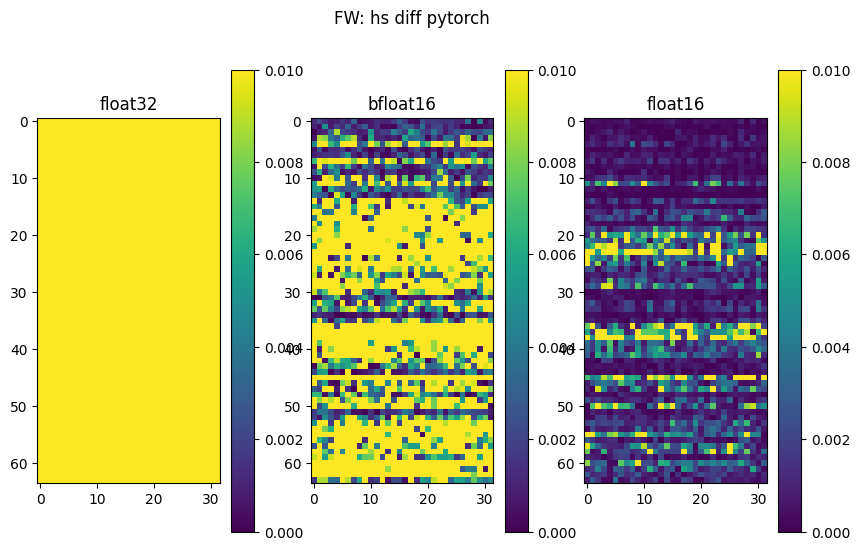

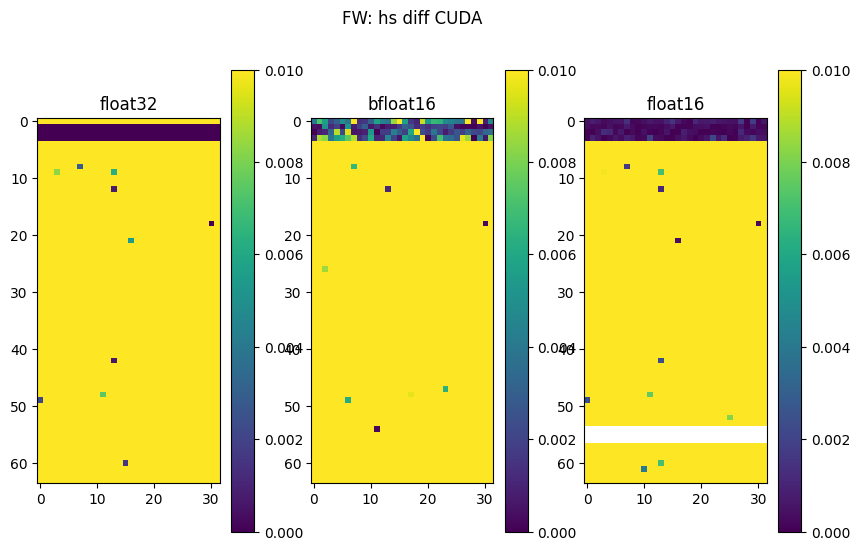

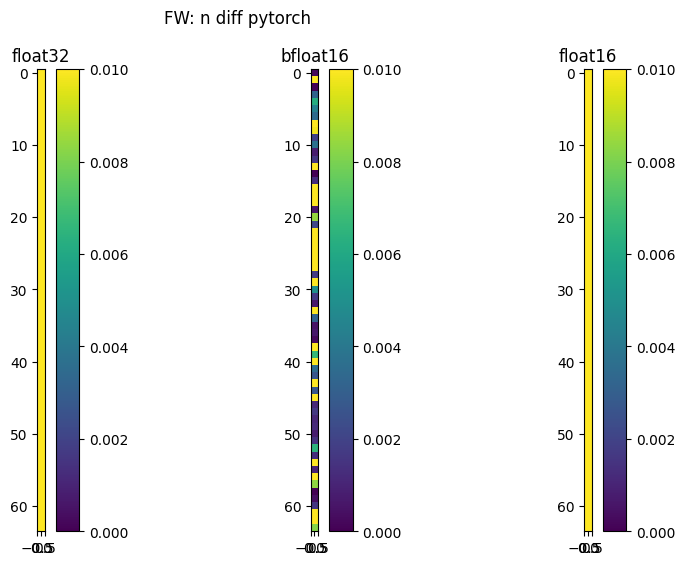

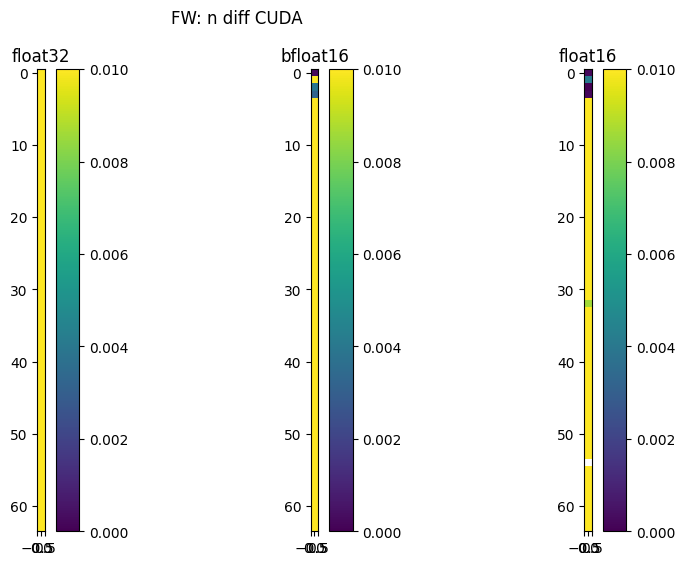

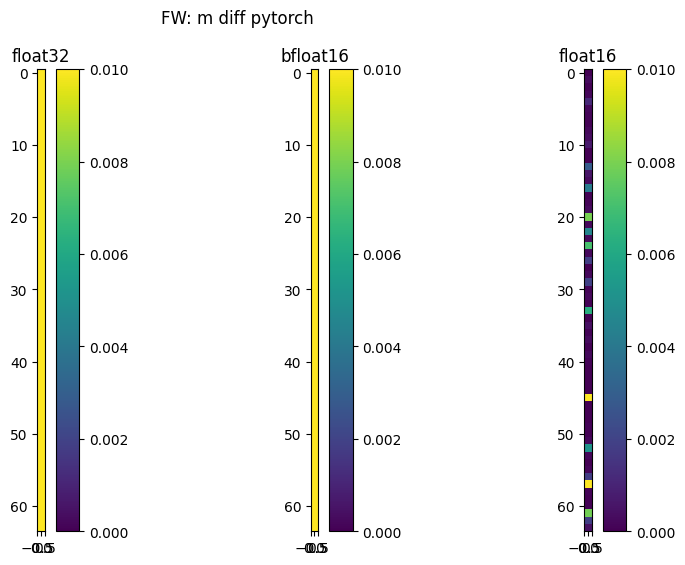

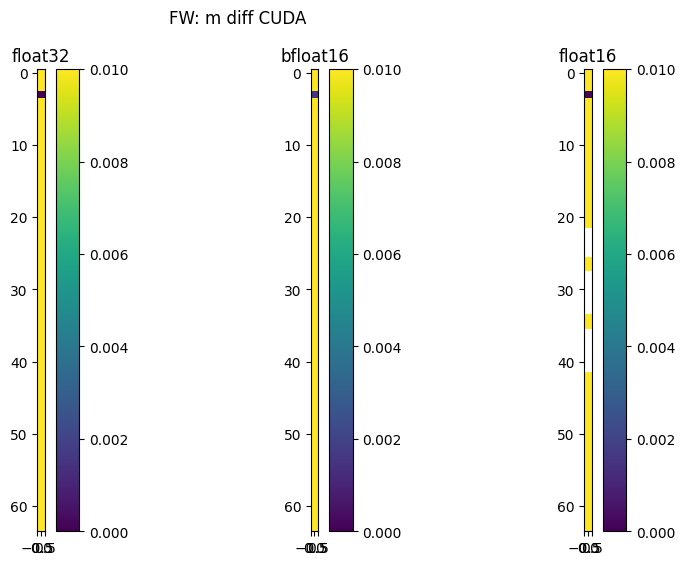

In [25]:
## fw diffs
# hs
fig = plot_numerical_diffs(hs_pt, 10*torch.ones_like(hs_pt), hs_pt_bf16, hs_pt_half, title="FW: hs diff pytorch")
fig = plot_numerical_diffs(hs_pt, hs_cu, hs_cu_bf16, hs_cu_half, title="FW: hs diff CUDA")
# n 
fig = plot_numerical_diffs(n_pt, 10*torch.ones_like(n_pt), n_pt_bf16, n_pt_half, title="FW: n diff pytorch")
fig = plot_numerical_diffs(n_pt, n_cu, n_cu_bf16, n_cu_half, title="FW: n diff CUDA")
# m
fig = plot_numerical_diffs(m_pt, 10*torch.ones_like(m_pt), m_pt_bf16, m_pt_half, title="FW: m diff pytorch")
fig = plot_numerical_diffs(m_pt, m_cu, m_cu_bf16, m_cu_half, title="FW: m diff CUDA")

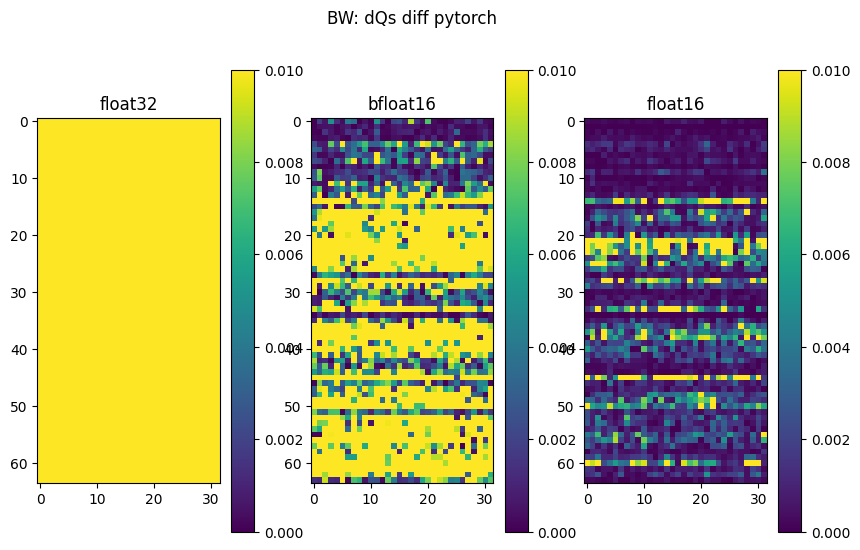

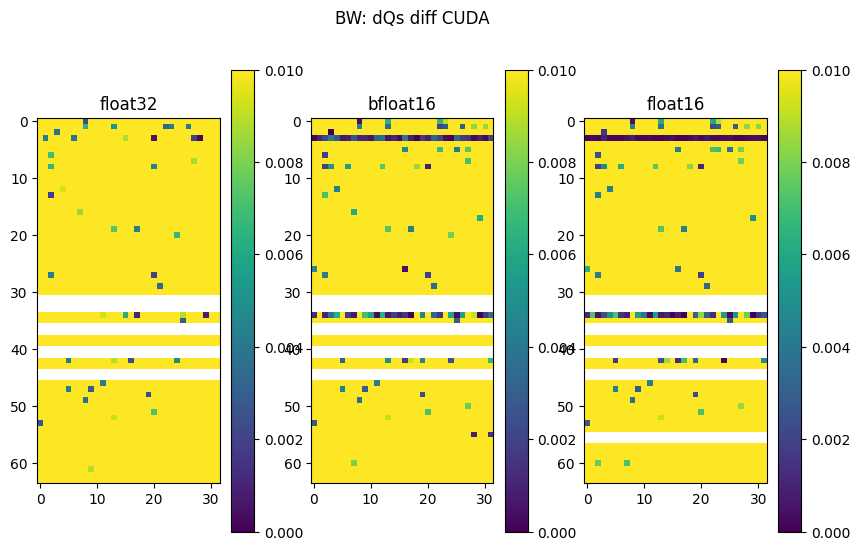

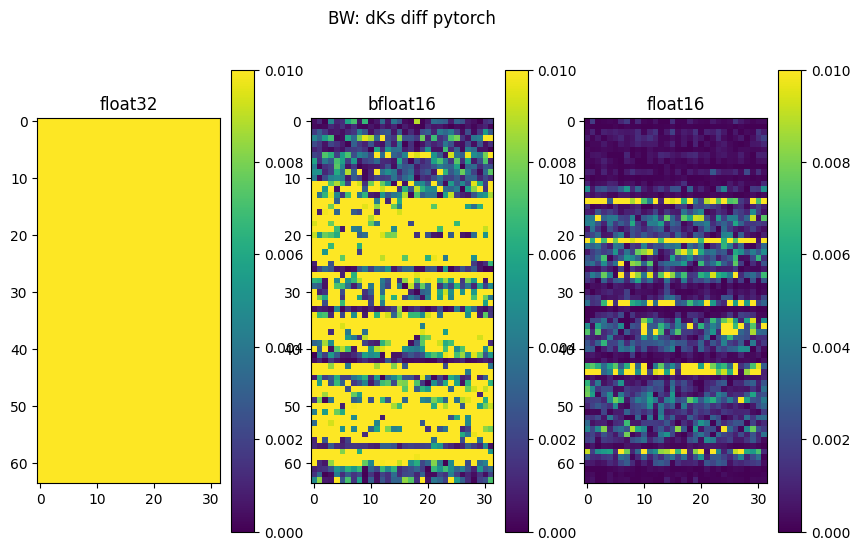

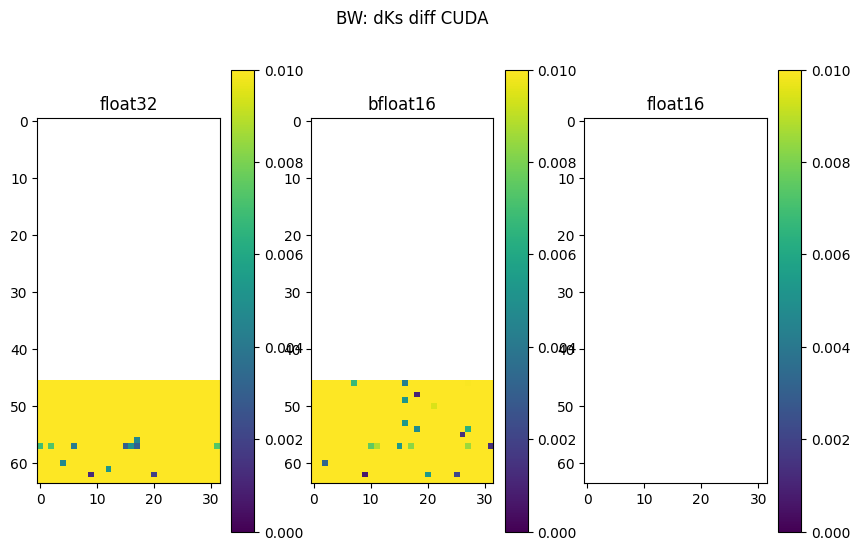

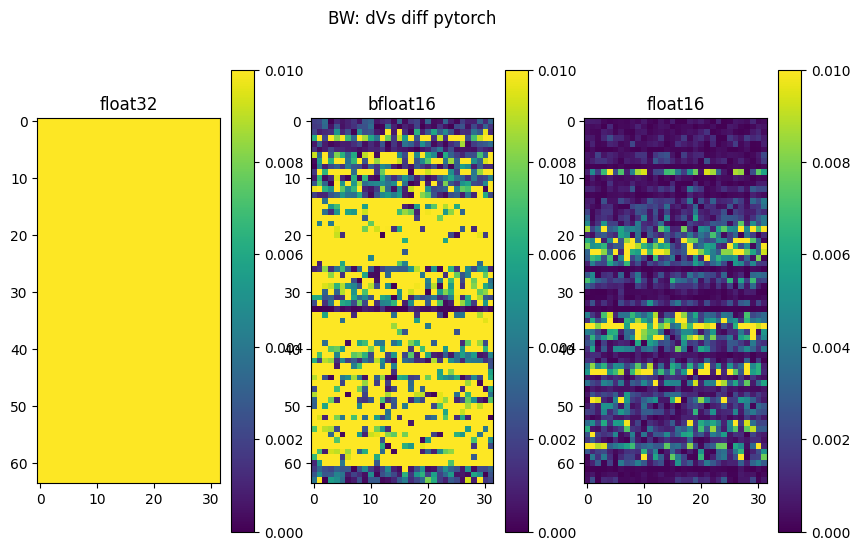

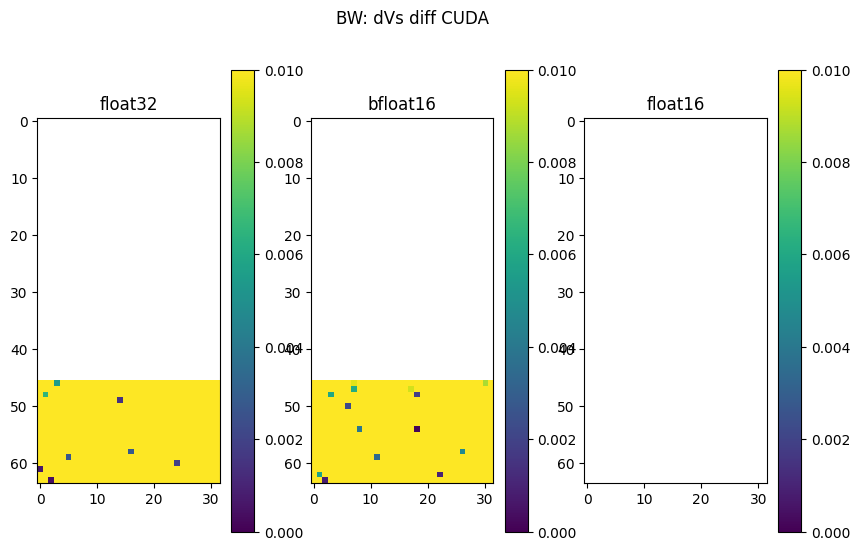

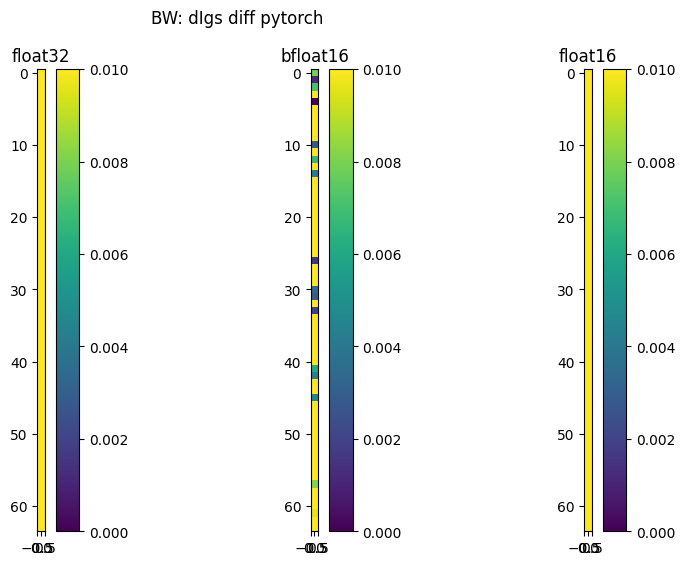

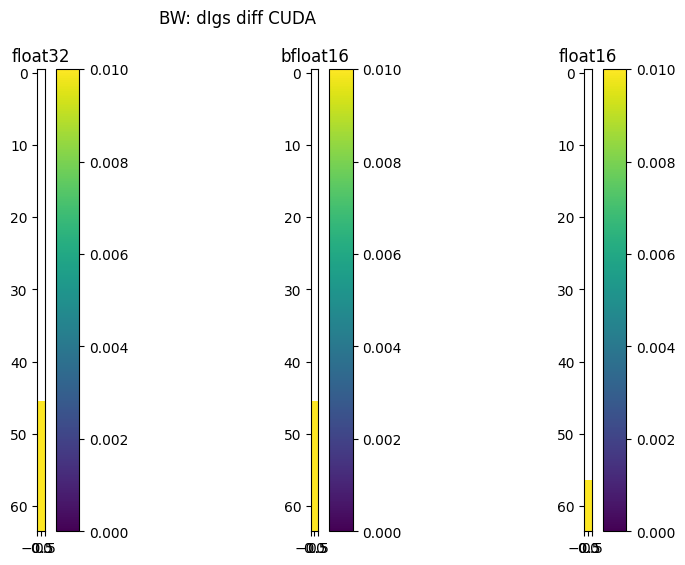

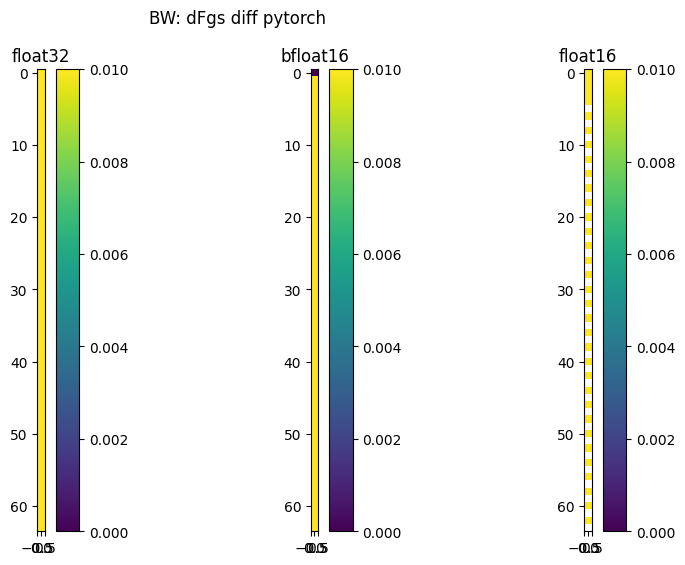

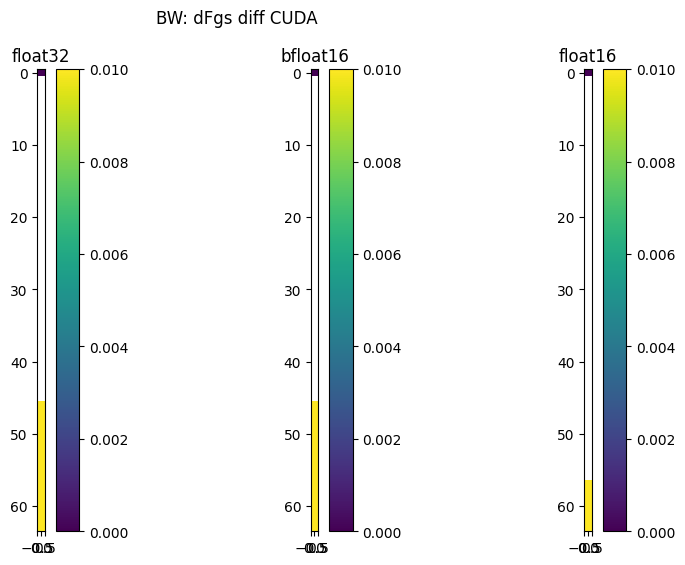

In [26]:
# bw diffs
# dQs
fig = plot_numerical_diffs(dQs_pt, 10*torch.ones_like(dQs_pt), dQs_pt_bf16, dQs_pt_half, title="BW: dQs diff pytorch")
fig = plot_numerical_diffs(dQs_pt, dQs_cu, dQs_cu_bf16, dQs_cu_half, title="BW: dQs diff CUDA")
# dKs
fig = plot_numerical_diffs(dKs_pt, 10*torch.ones_like(dKs_pt), dKs_pt_bf16, dKs_pt_half, title="BW: dKs diff pytorch")
fig = plot_numerical_diffs(dKs_pt, dKs_cu, dKs_cu_bf16, dKs_cu_half, title="BW: dKs diff CUDA")
# dVs
fig = plot_numerical_diffs(dVs_pt, 10*torch.ones_like(dVs_pt), dVs_pt_bf16, dVs_pt_half, title="BW: dVs diff pytorch")
fig = plot_numerical_diffs(dVs_pt, dVs_cu, dVs_cu_bf16, dVs_cu_half, title="BW: dVs diff CUDA")
# dIgs
fig = plot_numerical_diffs(dIgs_pt, 10*torch.ones_like(dIgs_pt), dIgs_pt_bf16, dIgs_pt_half, title="BW: dIgs diff pytorch")
fig = plot_numerical_diffs(dIgs_pt, dIgs_cu, dIgs_cu_bf16, dIgs_cu_half, title="BW: dIgs diff CUDA")
# dFgs
fig = plot_numerical_diffs(dFgs_pt, 10*torch.ones_like(dFgs_pt), dFgs_pt_bf16, dFgs_pt_half, title="BW: dFgs diff pytorch")
fig = plot_numerical_diffs(dFgs_pt, dFgs_cu, dFgs_cu_bf16, dFgs_cu_half, title="BW: dFgs diff CUDA")

### Debug float16 precision differences in cuda kernel

In [27]:
# float32 just for reference
hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)

before kernel dispatch - float32!
B: 1, NH: 1, S: 64, DH: 32
blocksxy: 1-2, threadsxy: 16-16, shared_mem in bytes: 98560
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 16, bdim.y: 16
In FW-Kernel: QtileDim: 64, KVtileDim: 64, TblockDim:16
qTIdx=0, kvTdx=0, cTBXY=(0,64), hWTXY=(0,0), hsXY[0,2]=-0.404515, sv_acc=-0.404515, wf_hprev=0.000000, n_val=0.654280, n_prev_val=0.000000, m_val=319318235545600.000000, m_prev_val=-0.000000
qTIdx=0, kvTdx=0, cTBXY=(0,64), hWTXY=(0,0), hsXY[0,3]=-0.422787, sv_acc=-0.422787, wf_hprev=0.000000, n_val=2.091439, n_prev_val=0.000000, m_val=217.516571, m_prev_val=-inf
qTIdx=0, kvTdx=0, cTBXY=(0,64), hWTXY=(0,0), hsXY[0,0]=-0.514074, sv_acc=-0.514074, wf_hprev=0.000000, n_val=0.237317, n_prev_val=0.000000, m_val=3008486078152704.000000, m_prev_val=0.000000
qTIdx=0, kvTdx=0, cTBXY=(0,64), hWTXY=(0,0), hsXY[0,1]=0.396001, sv_acc=0.396001, wf_hprev=0.000000, n_val=2.052640, n_prev_val=0.000000, m_val=1236025686884352.000000, m_prev_val=0.000000
qTIdx=0,

In [28]:
fgs

tensor([[[[-1.4286],
          [-1.0874],
          [ 0.5559],
          [ 1.0172],
          [-0.3479],
          [-1.3633],
          [-1.3168],
          [ 0.9415],
          [ 0.5776],
          [-0.4001],
          [-0.4550],
          [-0.5947],
          [-2.3788],
          [ 0.0537],
          [ 0.5271],
          [-0.2673],
          [ 0.1509],
          [ 0.3151],
          [-0.8073],
          [ 0.9548],
          [-0.7206],
          [ 0.2526],
          [ 0.8241],
          [-0.6592],
          [ 0.7642],
          [ 0.0181],
          [-0.6598],
          [ 0.6114],
          [ 0.2609],
          [-0.6826],
          [-0.8559],
          [-1.3082],
          [ 0.6555],
          [ 1.0994],
          [-3.3065],
          [ 1.0477],
          [ 1.7495],
          [ 0.0810],
          [-0.4557],
          [-1.1311],
          [-0.1796],
          [-1.4650],
          [ 0.1618],
          [-1.5969],
          [-0.5634],
          [ 0.1197],
          [ 0.1743],
          [-0

In [29]:
hs_cu_half, n_cu_half, m_cu_half, matD_cu_half = vlstm_fw_cuda(mat_Q=qs_half, mat_K=ks_half, mat_V=vs_half, vec_igp=igs_half, vec_fgp=fgs_half)

before kernel dispatch - float16!
B: 1, NH: 1, S: 64, DH: 32
blocksxy: 1-2, threadsxy: 16-16, shared_mem in bytes: 50432
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 16, bdim.y: 16
In FW-Kernel: QtileDim: 64, KVtileDim: 64, TblockDim:16
qTIdx=0, kvTdx=0, cTBXY=(0,64), hWTXY=(0,0), hsXY[0,0]=-0.520996, sv_acc=-0.520823, wf_hprev=0.000000, n_val=0.235352, n_prev_val=0.000000, m_val=inf, m_prev_val=0.000000
qTIdx=0, kvTdx=0, cTBXY=(0,64), hWTXY=(0,0), hsXY[0,1]=0.395508, sv_acc=0.395587, wf_hprev=0.000000, n_val=2.054688, n_prev_val=0.000000, m_val=inf, m_prev_val=0.000000
qTIdx=0, kvTdx=0, cTBXY=(0,64), hWTXY=(0,0), hsXY[0,2]=-0.404297, sv_acc=-0.404329, wf_hprev=0.000000, n_val=0.654297, n_prev_val=0.000000, m_val=inf, m_prev_val=-0.000000
qTIdx=0, kvTdx=0, cTBXY=(0,64), hWTXY=(0,0), hsXY[0,3]=-0.425781, sv_acc=-0.425706, wf_hprev=0.000000, n_val=2.080078, n_prev_val=0.000000, m_val=217.500000, m_prev_val=-inf
qTIdx=0, kvTdx=0, cTBXY=(0,64), hWTXY=(0,1), hsXY[0,16]=-0.427246, 

In [30]:
print(f"====== Half ======")
print(f"fw hs match: {torch.allclose(hs_cu_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_half.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_half - matD_pt).tril())}")

====== Half ======
fw hs match: False, max diff: nan
fw n match: False, max diff: inf
fw m match: False, max diff: inf
fw D match: False, max diff: 153.41070556640625


In [31]:
# matS = (qs @ ks.transpose(-2, -1) / (DH ** 0.5)).tril()
# matS[:,:, :, :10]

In [32]:
# (matD_cu_half - matS)[:, :, :, :10]

In [33]:
torch.nn.functional.logsigmoid(fgs_half)

tensor([[[[-1.6436],
          [-1.3779],
          [-0.4531],
          [-0.3086],
          [-0.8823],
          [-1.5908],
          [-1.5537],
          [-0.3293],
          [-0.4456],
          [-0.9131],
          [-0.9463],
          [-1.0342],
          [-2.4668],
          [-0.6665],
          [-0.4641],
          [-0.8359],
          [-0.6206],
          [-0.5479],
          [-1.1758],
          [-0.3257],
          [-1.1172],
          [-0.5747],
          [-0.3638],
          [-1.0762],
          [-0.3823],
          [-0.6841],
          [-1.0762],
          [-0.4336],
          [-0.5713],
          [-1.0918],
          [-1.2100],
          [-1.5479],
          [-0.4182],
          [-0.2874],
          [-3.3418],
          [-0.3005],
          [-0.1603],
          [-0.6533],
          [-0.9468],
          [-1.4102],
          [-0.7871],
          [-1.6729],
          [-0.6157],
          [-1.7812],
          [-1.0137],
          [-0.6353],
          [-0.6099],
          [-0

In [34]:
torch.nn.functional.logsigmoid(fgs)

tensor([[[[-1.6434],
          [-1.3779],
          [-0.4533],
          [-0.3087],
          [-0.8822],
          [-1.5911],
          [-1.5542],
          [-0.3293],
          [-0.4455],
          [-0.9131],
          [-0.9463],
          [-1.0341],
          [-2.4675],
          [-0.6667],
          [-0.4639],
          [-0.8357],
          [-0.6205],
          [-0.5480],
          [-1.1761],
          [-0.3256],
          [-1.1170],
          [-0.5748],
          [-0.3637],
          [-1.0761],
          [-0.3823],
          [-0.6841],
          [-1.0765],
          [-0.4335],
          [-0.5712],
          [-1.0916],
          [-1.2100],
          [-1.5475],
          [-0.4182],
          [-0.2875],
          [-3.3424],
          [-0.3007],
          [-0.1603],
          [-0.6534],
          [-0.9467],
          [-1.4108],
          [-0.7870],
          [-1.6729],
          [-0.6155],
          [-1.7813],
          [-1.0140],
          [-0.6351],
          [-0.6098],
          [-0

In [35]:
matD_cu_half[:,:, :, :10], matD_pt[:,:, :, :10]

(tensor([[[[ 1.6956e-01,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf],
           [-1.2070e+00, -1.2969e+00,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf],
           [-1.6602e+00, -1.7500e+00,  3.1519e-01,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf],
           [-1.9688e+00, -2.0586e+00,  6.8359e-03,  9.1943e-01,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf],
           [-2.8516e+00, -2.9395e+00, -8.7500e-01,  3.7598e-02, -2.8734e+01,        -inf,        -inf,        -inf,        -inf,        -inf],
           [-4.4414e+00, -4.5312e+00, -2.4648e+00, -1.5527e+00,  6.4180e+00, -1.0898e+00,        -inf,        -inf,        -inf,        -inf],
           [-5.9961e+00, -6.0859e+00, -4.0195e+00, -3.1074e+00,  4.8633e+00,  3.4094e+01, -2.6318e-01,        -inf,        -inf,        -inf],

### debug fw hs nans in last timesteps

In [36]:
# float32 just for reference
hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)

before kernel dispatch - float32!
B: 1, NH: 1, S: 64, DH: 32
blocksxy: 1-2, threadsxy: 16-16, shared_mem in bytes: 98560
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 16, bdim.y: 16
In FW-Kernel: QtileDim: 64, KVtileDim: 64, TblockDim:16
qTIdx=0, kvTdx=0, cTBXY=(0,64), hWTXY=(0,0), hsXY[0,0]=-0.514074, sv_acc=-0.514074, wf_hprev=0.000000, n_val=0.237317, n_prev_val=0.000000, m_val=3008486078152704.000000, m_prev_val=0.000000
qTIdx=0, kvTdx=0, cTBXY=(0,64), hWTXY=(0,0), hsXY[0,1]=0.396001, sv_acc=0.396001, wf_hprev=0.000000, n_val=2.052640, n_prev_val=0.000000, m_val=1236025686884352.000000, m_prev_val=0.000000
qTIdx=0, kvTdx=0, cTBXY=(0,64), hWTXY=(0,0), hsXY[0,2]=-0.404515, sv_acc=-0.404515, wf_hprev=0.000000, n_val=0.654280, n_prev_val=0.000000, m_val=319318235545600.000000, m_prev_val=-0.000000
qTIdx=0, kvTdx=0, cTBXY=(0,64), hWTXY=(0,0), hsXY[0,3]=-0.422787, sv_acc=-0.422787, wf_hprev=0.000000, n_val=2.091439, n_prev_val=0.000000, m_val=217.516571, m_prev_val=-inf
qTIdx=0,

In [37]:
hs_cu_half, n_cu_half, m_cu_half, matD_cu_half = vlstm_fw_cuda(mat_Q=qs_half, mat_K=ks_half, mat_V=vs_half, vec_igp=igs_half, vec_fgp=fgs_half)

before kernel dispatch - float16!
B: 1, NH: 1, S: 64, DH: 32
blocksxy: 1-2, threadsxy: 16-16, shared_mem in bytes: 50432
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 16, bdim.y: 16
In FW-Kernel: QtileDim: 64, KVtileDim: 64, TblockDim:16
qTIdx=0, kvTdx=0, cTBXY=(0,64), hWTXY=(0,0), hsXY[0,0]=-0.520996, sv_acc=-0.520823, wf_hprev=0.000000, n_val=0.235352, n_prev_val=0.000000, m_val=inf, m_prev_val=0.000000
qTIdx=0, kvTdx=0, cTBXY=(0,64), hWTXY=(0,0), hsXY[0,1]=0.395508, sv_acc=0.395587, wf_hprev=0.000000, n_val=2.054688, n_prev_val=0.000000, m_val=inf, m_prev_val=0.000000
qTIdx=0, kvTdx=0, cTBXY=(0,64), hWTXY=(0,0), hsXY[0,2]=-0.404297, sv_acc=-0.404329, wf_hprev=0.000000, n_val=0.654297, n_prev_val=0.000000, m_val=inf, m_prev_val=-0.000000
qTIdx=0, kvTdx=0, cTBXY=(0,64), hWTXY=(0,0), hsXY[0,3]=-0.425781, sv_acc=-0.425706, wf_hprev=0.000000, n_val=2.080078, n_prev_val=0.000000, m_val=217.500000, m_prev_val=-inf
qTIdx=0, kvTdx=0, cTBXY=(0,64), hWTXY=(0,1), hsXY[0,18]=0.406494, s

In [38]:
hs_cu_half[:, :, 20:30, :10]

tensor([[[[-0.8818,  0.0866, -1.6533,  0.2111, -0.1953,  0.8369, -0.6357,  0.6978,  0.4502, -0.0264],
          [ 0.9336, -0.1444,  1.8564, -0.0276,  0.6982, -0.4155,  0.7285, -0.1356, -1.2461,  0.3750],
          [ 1.0938,  1.0615, -1.4355,  1.5322,  1.3037, -1.4619,  0.2573, -1.8711, -0.3416, -1.0674],
          [-1.0977, -1.0371,  1.3574, -1.5010, -1.2686,  1.4092, -0.2590,  1.8457,  0.3369,  1.0576],
          [-1.0938, -1.0684,  1.4590, -1.5420, -1.3145,  1.4785, -0.2571,  1.8789,  0.3430,  1.0703],
          [ 1.0967,  1.0400, -1.3662,  1.5049,  1.2715, -1.4150,  0.2588, -1.8486, -0.3372, -1.0586],
          [ 1.0938,  1.0635, -1.4434,  1.5352,  1.3076, -1.4668,  0.2573, -1.8740, -0.3420, -1.0684],
          [-1.0928, -1.0645,  1.4443, -1.5352, -1.3076,  1.4678, -0.2571,  1.8740,  0.3420,  1.0684],
          [ 1.0938,  1.0537, -1.4111,  1.5225,  1.2920, -1.4453,  0.2578, -1.8633, -0.3401, -1.0645],
          [-1.0928, -1.0664,  1.4521, -1.5391, -1.3115,  1.4736, -0.2571,  1.8760,

In [39]:
n_cu[:, :, 120:]

tensor([], device='cuda:0', size=(1, 1, 0, 1))

In [40]:
(hs_cu-hs_pt)[:, :, 120:, :10]

tensor([], device='cuda:0', size=(1, 1, 0, 10))

In [41]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"Match against pt float32:")
print(f"====== Full ======")
print(f"fw hs match: {torch.allclose(hs_cu, hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu, n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu, m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu - matD_pt).tril(), torch.zeros_like((matD_cu)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu - matD_pt).tril())}")


Match against pt float32:
====== Full ======
fw hs match: False, max diff: 10.905182838439941
fw n match: False, max diff: 5603316224.0
fw m match: False, max diff: 3765333248.0
fw D match: False, max diff: 153.36798095703125


### debug fw hs for Q64xKV64

In [42]:
# float32 just for reference
hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)

before kernel dispatch - float32!
B: 1, NH: 1, S: 64, DH: 32
blocksxy: 1-2, threadsxy: 16-16, shared_mem in bytes: 98560
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 16, bdim.y: 16
In FW-Kernel: QtileDim: 64, KVtileDim: 64, TblockDim:16
qTIdx=0, kvTdx=0, cTBXY=(0,64), hWTXY=(0,0), hsXY[0,0]=-0.514074, sv_acc=-0.514074, wf_hprev=0.000000, n_val=0.237317, n_prev_val=0.000000, m_val=3008486078152704.000000, m_prev_val=0.000000
qTIdx=0, kvTdx=0, cTBXY=(0,64), hWTXY=(0,0), hsXY[0,1]=0.396001, sv_acc=0.396001, wf_hprev=0.000000, n_val=2.052640, n_prev_val=0.000000, m_val=1236025686884352.000000, m_prev_val=0.000000
qTIdx=0, kvTdx=0, cTBXY=(0,64), hWTXY=(0,0), hsXY[0,2]=-0.404515, sv_acc=-0.404515, wf_hprev=0.000000, n_val=0.654280, n_prev_val=0.000000, m_val=319318235545600.000000, m_prev_val=-0.000000
qTIdx=0, kvTdx=0, cTBXY=(0,64), hWTXY=(0,0), hsXY[0,3]=-0.422787, sv_acc=-0.422787, wf_hprev=0.000000, n_val=2.091439, n_prev_val=0.000000, m_val=217.516571, m_prev_val=-inf
qTIdx=0,

In [43]:
(hs_cu - hs_pt)[:,:, :60, :10] 

tensor([[[[-2.9802e-08, -5.2154e-08,  4.4703e-08,  1.4901e-08,  2.6077e-08,  3.7253e-08, -3.7253e-08,  8.9407e-08,  9.3132e-09,  1.3039e-08],
          [-1.4901e-08,  2.9802e-08, -1.1921e-07,  2.9802e-08,  4.4703e-08, -5.9605e-08,  1.1921e-07, -1.4901e-08,  5.9605e-08, -8.9407e-08],
          [ 0.0000e+00, -7.4506e-09,  2.9802e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  2.9802e-08,  0.0000e+00,  0.0000e+00],
          [-4.4703e-08,  0.0000e+00, -1.1921e-07, -2.3842e-07, -2.3842e-07,  1.1921e-07,  2.3842e-07,  0.0000e+00, -1.1921e-07, -2.9802e-08],
          [-6.6690e-01, -2.2201e+00, -7.4909e-01, -1.2141e-01, -6.8082e-01,  5.6918e-02,  1.4722e-01,  1.6445e+00, -1.6184e+00, -3.9476e-01],
          [ 7.8684e-01,  1.9525e+00,  7.3230e-01,  4.7146e-01,  9.8221e-01, -3.2575e-01, -1.5736e-01, -1.2817e+00,  2.1718e+00,  2.6435e-01],
          [ 4.5921e-01,  5.2526e-01,  1.1790e+00,  1.5433e+00, -5.3677e-01, -1.3900e+00, -2.0174e-01, -7.4062e-01,  9.3387e-01,  8.8435e-02],
      

In [44]:
(matD_cu - matD_pt)[:,:, :60, :10] 

tensor([[[[ 0.0000e+00,         nan,         nan,         nan,         nan,         nan,         nan,         nan,         nan,         nan],
          [-2.3842e-07,  0.0000e+00,         nan,         nan,         nan,         nan,         nan,         nan,         nan,         nan],
          [-2.3842e-07,  0.0000e+00,  0.0000e+00,         nan,         nan,         nan,         nan,         nan,         nan,         nan],
          [-2.3842e-07,  0.0000e+00,  0.0000e+00,  0.0000e+00,         nan,         nan,         nan,         nan,         nan,         nan],
          [-4.7684e-07,  0.0000e+00, -2.3842e-07, -1.7881e-07, -2.8555e+01,         nan,         nan,         nan,         nan,         nan],
          [-4.7684e-07,  0.0000e+00, -2.3842e-07, -2.3842e-07,  8.1847e+00,  0.0000e+00,         nan,         nan,         nan,         nan],
          [-4.7684e-07, -4.7684e-07, -4.7684e-07, -4.7684e-07,  8.1847e+00,  3.6740e+01,  0.0000e+00,         nan,         nan,         nan],
      

In [45]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"Match against pt float32:")
print(f"====== Full ======")
print(f"fw hs match: {torch.allclose(hs_cu, hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu, n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu, m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu - matD_pt).tril(), torch.zeros_like((matD_cu)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu - matD_pt).tril())}")


Match against pt float32:
====== Full ======
fw hs match: False, max diff: 10.905182838439941
fw n match: False, max diff: 5603316224.0
fw m match: False, max diff: 3765333248.0
fw D match: False, max diff: 153.36798095703125


In [46]:
(matD_pt_half - matD_pt)[:,:, :60, :10]

tensor([[[[ -134.1696,        inf,        inf,        inf,        inf,        inf,        inf,        inf,        nan,        nan],
          [ -133.4167,  -132.7034,        inf,        inf,        inf,        inf,        inf,        inf,        inf,        nan],
          [ -133.7134,  -132.8750,  -134.3152,        inf,        inf,        inf,        inf,        inf,        inf,        inf],
          [ -134.0297,  -133.3164,  -134.6316,  -134.9196,        inf,        inf,        inf,        inf,        inf,        inf],
          [ -133.8975,  -133.0592,  -134.4994,  -134.6624,  -128.8147,        inf,        inf,        inf,        inf,        inf],
          [ -132.9315,  -132.2182,  -133.5334,  -133.8214,  -127.9736,    23.3084,        inf,        inf,        inf,        inf],
          [ -132.1272,  -131.2889,  -132.7291,  -132.8922,  -127.0444,    24.1751,    22.4821,        inf,        inf,        inf],
          [ -132.4229,  -131.7096,  -133.0248,  -133.3128,  -127.4651,    23